In [70]:
from os import listdir
from os.path import join, isfile
from deap import base, creator, tools, algorithms

import random
import numpy as np
import matplotlib.pyplot as plt


In [71]:
def get_data_from_file(path: str):
    with open(path, "r") as f:
        data = []
        lines = f.readlines()
        for line in lines:
            data.append([int(c) for c in line.split()])
        return data


def get_paths_of_dir(path: str, extension: str):
    return [join(path, f) for f in listdir(path)
            if isfile(join(path, f)) and f.endswith(extension)]

In [72]:
inDirPath = "../../Input/"
inPaths = get_paths_of_dir(inDirPath, extension=".in")

In [73]:
n_problem = int(input("Elige el problema (1-5): "))

inDirFiles = listdir(inDirPath)
file_name = inDirFiles[n_problem - 1]

path = inPaths[n_problem - 1]
prob = get_data_from_file(path)

## Variable meanings.

* R = Number of rows.
* C = Number of columns.
* F = Number of cars.
* N = Pre-booked rides.
* B = Per-ride bonus for starting the ride on time.
* T = Simulation steps = distance between start and end.

In [74]:
# Problem data.
_, _, F, N, B, T = prob[0]

# Rides.
rides = prob[1:-1]

# Car accessibility.
adapted = prob[-1]

Bonus:
* Earn points proportional to distance of ride.
* Bonus if started on time. 

In [75]:
toolbox = base.Toolbox()

In [76]:
creator.create("FitnessMax", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [77]:
toolbox.register("attribute", random.randint, 0, F - 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [78]:
def sort_rides(car_rides):
    def sort_ride(ride):
        a, b, x, y, s, f, _ = ride
        origin = [a, b]
        destiny = [x, y]
        distance = dis(origin, destiny)

        return s + f - distance
    
    return sorted(car_rides, key=lambda ride: sort_ride(ride[1]))

def get_rides_from_ind(individual):
    cars_rides = np.full(F, None)
    
    for i, car in enumerate(individual):
        v_r = cars_rides[car]
        
        if v_r is None:
            v_r = []
            
        ride = rides[i]
        v_r.append([i, ride])
        
        cars_rides[car] = v_r

    return cars_rides

def dis(a, b): return np.abs(a[0] - b[0]) + np.abs(a[1]-b[1])


In [79]:
def calc_fitness(car, car_rides):
    fitness = 0
    penalty = 0
    step = 0
    pos = [0, 0]

    # Sort car_rides given earliest time.
    car_rides = sort_rides(car_rides)

    for _, ride in car_rides:
        a, b, x, y, earliest_start, latest_finish, adapted_ride = ride
        origin = [a, b]
        destiny = [x, y]

        adapted_car = adapted[car]

        if adapted_car == 0 and adapted_ride == 1:
            penalty += 10

        # 1.- Go to origin.
        step += dis(pos, origin)

        # 2.- If arrived before the earliest time. Wait and earn bonus.
        if step <= earliest_start:
            fitness += B
            step = earliest_start

        # 3.- Go to destiny.
        dis_ori_des = dis(origin, destiny)
        step += dis_ori_des

        # 4.- If reached destiny before latest finish. Earn points.
        if step <= latest_finish:
            fitness += dis_ori_des

        # 5.- Update position.
        pos = destiny

        # 6.- Check if reached max distance with one car.
        if step > T:
            break

    return fitness, penalty


def eval_ind(ind):
    all_rides = get_rides_from_ind(ind)

    fitness = 0
    penalty = 0

    for car, car_rides in enumerate(all_rides):
        if car_rides is not None:
            _fitness, _penalty = calc_fitness(car, car_rides)
            fitness += _fitness
            penalty += _penalty

    return fitness, penalty


In [80]:

NIND = 30

pop = toolbox.population(n=NIND)
hof = tools.ParetoFront()
# print(f"Population: {pop}")

In [81]:
ind = toolbox.individual()

# print("Individuo ANTES de evaluar")
# print(ind)
# print(ind.fitness.valid)
# print("\n")

# ind.fitness.values = eval_ind(ind)

# print("Individuo TRAS evaluar")
# print(ind)
# print(ind.fitness.valid)
# print(ind.fitness)

In [82]:
INDPB = 0.2

toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, indpb=INDPB, low=0, up=F-1)
toolbox.register("evaluate", eval_ind)


In [83]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_penalty = tools.Statistics(lambda ind: ind.fitness.values)
mstats = tools.MultiStatistics(fitness=stats_fit, penalty=stats_penalty)

mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)


In [84]:
NGEN = 20
MU = 50
LAMBDA = 2*MU
CXPB = 0.7
MUTPB = 0.2

pop, logbook = algorithms.eaMuPlusLambda(
    pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, mstats, halloffame=hof, verbose=False)

best_sol = tools.selBest(pop, 1)[0]

print(f"El resultado de la evolución es:")
print(logbook)
print(f"La mejor solucion encontrada es: {best_sol}")


El resultado de la evolución es:
   	      	                   fitness                    	                   penalty                    
   	      	----------------------------------------------	----------------------------------------------
gen	nevals	avg   	gen	max   	min   	nevals	std   	avg   	gen	max   	min   	nevals	std   
0  	30    	414823	0  	760000	156819	30    	252603	414823	0  	760000	156819	30    	252603
1  	96    	398767	1  	730000	159825	96    	233853	398767	1  	730000	159825	96    	233853
2  	95    	388495	2  	710000	160421	95    	222904	388495	2  	710000	160421	95    	222904
3  	92    	380325	3  	700000	161458	92    	213799	380325	3  	700000	161458	92    	213799
4  	92    	376896	4  	660000	160900	92    	210239	376896	4  	660000	160900	92    	210239
5  	92    	364871	5  	660000	160819	92    	198431	364871	5  	660000	160819	92    	198431
6  	88    	358352	6  	660000	158682	88    	192287	358352	6  	660000	158682	88    	192287
7  	93    	355663	7  	650000	165462	93    	18

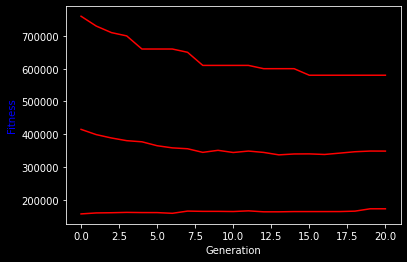

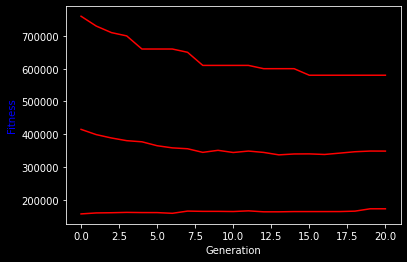

In [85]:
fitness = logbook.chapters["fitness"]
penalty = logbook.chapters["penalty"]


def plot(stats):
    gen = stats.select("gen")
    avgs = stats.select("avg")
    mins = stats.select("min")
    maxs = stats.select("max")

    fig = plt.figure()

    ax = plt.gca()
    line = ax.plot(gen, maxs, "r-", label="Average Fitness")
    line = ax.plot(gen, avgs, "r-", label="Average Fitness")
    line = ax.plot(gen, mins, "r-", label="Average Fitness")
    ax.set_xlabel("Generation")
    ax.set_ylabel("Fitness", color="b")

    plt.plot()


plot(fitness)
plot(penalty)


In [86]:
outDirPath = "../../Output/"
outFilePath = outDirPath + file_name.strip(".in") + ".out"

cars_rides = get_rides_from_ind(best_sol)

with open(outFilePath, "w") as f:
    for v_r in cars_rides:
      if v_r is None:
        f.write(str(0))
      else:
        v_r = sort_rides(v_r)    
        f.write(str(len(v_r)))
        f.write(" ")
        f.write(" ".join(str(pos) for pos, _ in v_r))
      
      f.write("\n")